# Goodreads Exploratory Analysis

Exploratory analysis of the goodreads datasets. This analysis is applied to the poetry books of the goodreads dataset.

### Imports

In [1]:
import json
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
plt.style.use('seaborn-darkgrid')
%matplotlib inline

### Loading data

In [2]:
def load_and_sample_dataset(data_path, sample_percentage):
    """Used to load `sample_percentage`% of the data at `data_path`.
    
    Parameters
    ----------
    data_path: str
        A string representing the path to the data
    sample_percentage: float
        A number between 0 and 100 representing the fraction
        of the data to sample.
    
    Returns
    -------
    pd.DataFrame
        A pandas dataframe object loaded from `data_path` after
        loading `sample_percentage`% of the data.
    
    """
    data = []
    idx = 0
    modulus = 100 // sample_percentage
    with open(data_path, 'r') as data_file:
        for row in data_file:
            if idx % modulus == 0:
                data.append(json.loads(row))
            idx += 1
    return pd.DataFrame(data)

In [3]:
def construct_data_path(dataset_name):
    """Constructs the path to `dataset_name`.
    
    Parameters
    ----------
    dataset_name: str
        The name of the dataset.
    
    Returns
    -------
    str
        A path to the dataset.
    
    """
    return os.path.join('data', '{}.json'.format(dataset_name))

In [4]:
interactions_df = load_and_sample_dataset(construct_data_path('goodreads_interactions_poetry'), 10)

In [5]:
books_df = load_and_sample_dataset(construct_data_path('goodreads_books_poetry'), 100)

In [6]:
reviews_df = load_and_sample_dataset(construct_data_path('goodreads_reviews_poetry'), 100)

### Merging data

In [7]:
all_interactions_df = pd.merge(interactions_df, books_df, how='left', left_on="book_id", right_on="book_id")

In [11]:
columns_to_keep = ['review_id', 'review_text', 'n_votes', 'n_comments']
new_cols = ['review_id', 'review_text', 'n_votes', 'n_comments']
reviews_df = reviews_df[columns_to_keep]
reviews_df.columns = new_cols
combined_df = pd.merge(all_interactions_df, reviews_df, how='left', left_on='review_id', right_on='review_id')
reviews_df = combined_df[~pd.isnull(combined_df['review_text'])]

In [12]:
all_interactions_df.describe()

,rating
count,273435.000000
mean,1.826763
std,2.122692
min,0.000000
25%,0.000000
50%,0.000000
75%,4.000000
max,5.000000


In [13]:
reviews_df.describe()

,rating,n_votes,n_comments
count,15467.000000,15467.000000,15467.000000
mean,3.818129,1.533070,0.254154
std,1.303027,6.190663,1.626551
min,0.000000,-1.000000,0.000000
25%,3.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000
75%,5.000000,1.000000,0.000000
max,5.000000,259.000000,76.000000


It is definitely clear that ratings are biased upwards when a review is present

### Date Formatting and Visualization

In [14]:
def format_publication_date(data_df):
    """Formats the publication date in `data_df`.
    
    The formatted publication date has the form 'yyyy-mm'.
    
    Parameters
    ----------
    data_df: pd.DataFrame
        The pandas DataFrame for which the publication date will be formatted.
    
    Returns
    -------
    pd.DataFrame
        The pandas DataFrame obtained from `data_df` after adding a column
        for the formatted publication date.
    
    """
    data_df['formatted_pub_month'] = data_df['publication_month'].apply(lambda x: str(x).zfill(2))
    data_df['formatted_pub_year'] = data_df['publication_year'].apply(lambda x: str(x))
    data_df['pub_date'] = data_df['formatted_pub_year'] + "-" + data_df['formatted_pub_month']
    data_df = data_df.drop(columns=['formatted_pub_year', 'formatted_pub_month'])
    return data_df

In [15]:
month_map = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06',
             'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}

def reformat_date_cols(data_df, date_cols):
    """Reformats date columns in `data_df` for easier analysis.
    
    The columns in `date_cols` are formatted in a way that is
    easier to visualize. The reformatted date columns have the
    format 'yyyy-mm'
    
    Parameters
    ----------
    data_df: pd.DataFrame
        A pandas DataFrame to which date columns will be added.
    date_cols: collection
        A collection of date columns to be reformatted
    
    Returns
    -------
    pd.DataFrame
        A pandas DataFrame obtained from `data_df` by augmenting it with
        reformatted date columns for the columns in `date_cols`.
    
    """
    for date_col in date_cols:
        col_name = date_col.split("_")[1]
        month_name = "month_{}".format(col_name)
        year_name = "year_{}".format(col_name)
        data_df[month_name] = data_df[date_col].apply(lambda x: month_map[x.split()[1]])
        data_df[year_name] = data_df[date_col].apply(lambda x: x.split()[-1])
        data_df['year_month_{}'.format(col_name)] = data_df[year_name] + "-" + data_df[month_name]
        data_df = data_df.drop(columns=[month_name, year_name])
    return data_df

In [16]:
all_interactions_df = reformat_date_cols(all_interactions_df, ['date_added', 'date_updated'])
all_interactions_df = format_publication_date(all_interactions_df)

books_df = format_publication_date(books_df)

reviews_df = reformat_date_cols(reviews_df, ['date_added', 'date_updated'])
reviews_df = format_publication_date(reviews_df)

<ipython-input-15-febda3f22134>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df[month_name] = data_df[date_col].apply(lambda x: month_map[x.split()[1]])
<ipython-input-15-febda3f22134>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df[year_name] = data_df[date_col].apply(lambda x: x.split()[-1])
<ipython-input-15-febda3f22134>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [17]:
def visualize_mean_rating_by_month(data_df, month_col, color='red'):
    """Visualizes the average rating in `data_df` by `month_col`.
    
    Parameters
    ----------
    data_df: pd.DataFrame
        The pandas dataframe containing the data to be visualized.
    month_col: str
        The name of the column in `data_df` over which the average
        rating will be visualized.
    color: str
        The color used to show the plot. The default is "red"
    
    Returns
    -------
    None
    
    """
    grouped_date = data_df.groupby(data_df[month_col])['rating'].mean()
    tick_labels = [x if x[-2:] == '06' else '' for x in grouped_date.index]
    
    plt.figure(figsize=(20,5))
    grouped_date.plot(color=color, linewidth=3)
    plt.xticks(range(len(tick_labels)), tick_labels)
    plt.ylim(0, 5)
    plt.show()

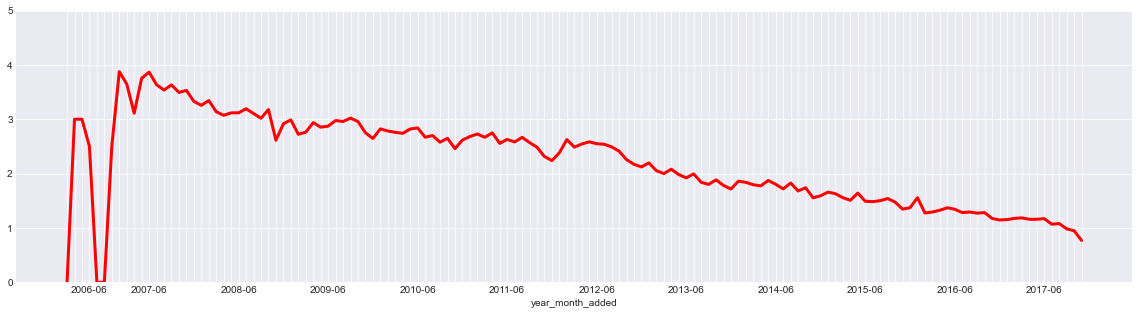

In [18]:
visualize_mean_rating_by_month(all_interactions_df, 'year_month_added')

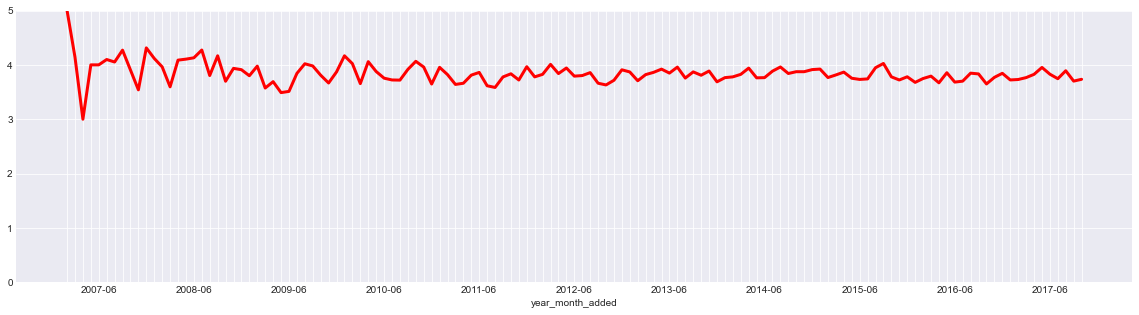

In [19]:
visualize_mean_rating_by_month(reviews_df, 'year_month_added')

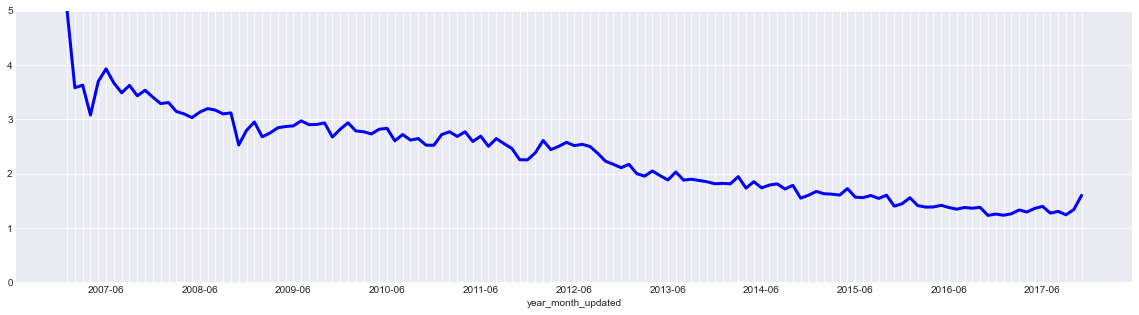

In [20]:
visualize_mean_rating_by_month(all_interactions_df, 'year_month_updated', color='blue')

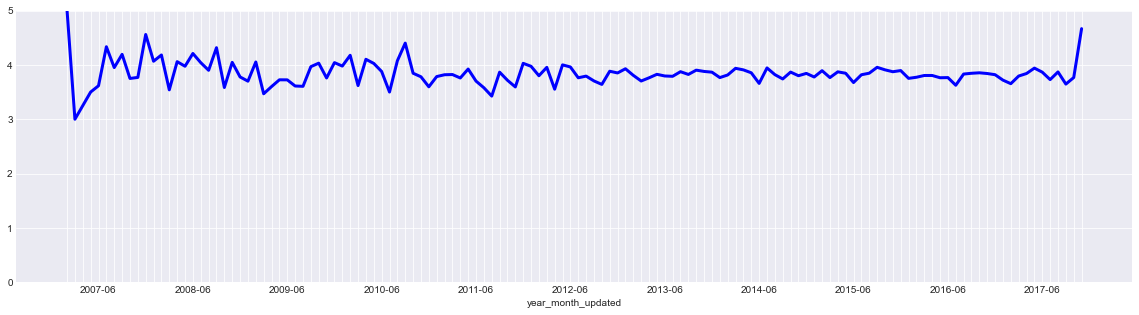

In [21]:
visualize_mean_rating_by_month(reviews_df, 'year_month_updated', color='blue')

In [22]:
def visualize_mean_rating_by_pub_date(data_df):
    """Visualizes the average rating in `data_df` by publication date.
    
    Parameters
    ----------
    data_df: pd.DataFrame
        The pandas dataframe containing the data to be visualized.
    
    Returns
    -------
    None
    
    """
    grouped_date = data_df.groupby(data_df['pub_date'])['rating'].mean()
    tick_labels = [x if x[-4:] == '5-06' else '' for x in grouped_date.index]
    
    plt.figure(figsize=(20,5))
    grouped_date.plot(color='orange', linewidth=3)
    plt.xticks(range(len(tick_labels)), tick_labels)
    plt.ylim(0, 5)
    plt.show()

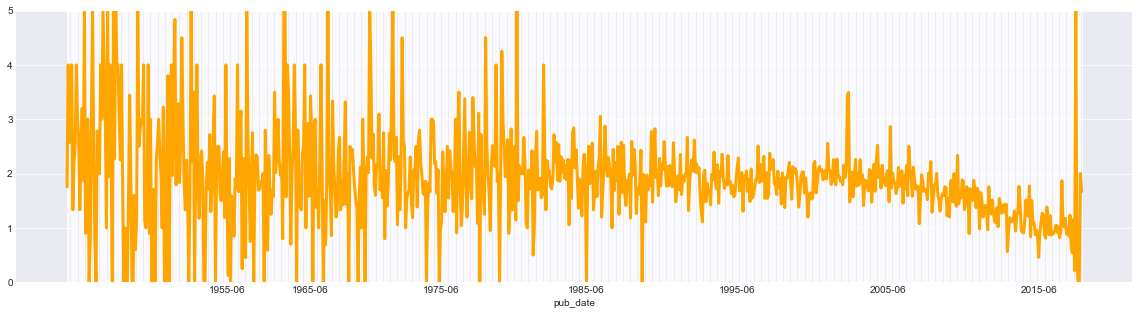

In [23]:
visualize_mean_rating_by_pub_date(all_interactions_df)

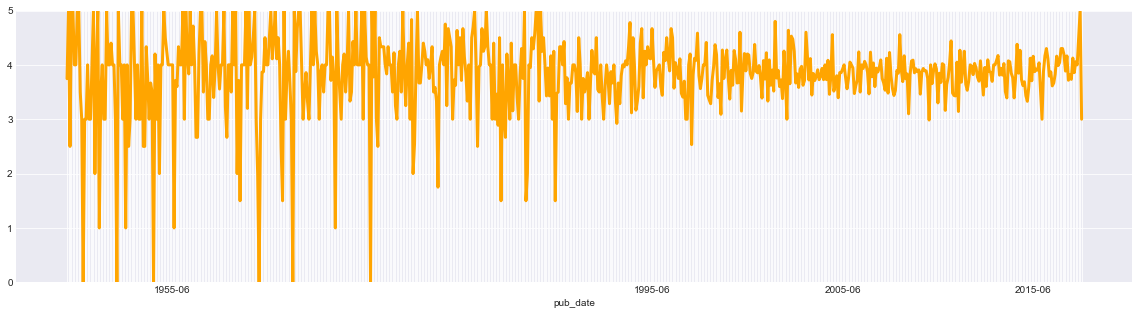

In [24]:
visualize_mean_rating_by_pub_date(reviews_df)